# Probability of recession model

## Initialize Libraries

In [1]:
from __future__ import absolute_import, division, print_function

%load_ext autoreload
%autoreload 2
#%matplotlib inline
%matplotlib inline
#%config InlineBackend.figure_formats = set(['png'])

import sys
#sys.path.append("/Documents/17. Work/Code Library/WoE")
from WoE import WoE
import os


import numpy as np
import pandas as pd
from pandas import ExcelWriter
import pandas_datareader.data as web
from pandas_datareader._utils import RemoteDataError
from sklearn.decomposition import KernelPCA
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import fredapi as fred
import math
import matplotlib.collections as collections
from bokeh.plotting import output_file, figure, show
import pylab as pl
from io import StringIO
import datetime as dt

import statsmodels.api as sm
from statsmodels.formula.api import logit, probit, poisson, ols
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import numpy as np

# Display and Plotting
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Download data from St Louis Federal Reserve

In [2]:
#Define Start and End time frame
start = dt.datetime(1950, 1, 1)
end = dt.datetime(2017, 12, 31)

,USREC
DATE,
2017-08,0
2017-09,0
2017-10,0
2017-11,0
2017-12,0


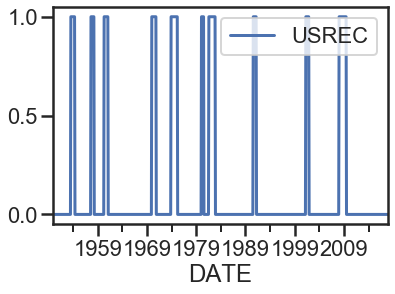

In [3]:
#US recessoin data
usrec = web.DataReader("USREC", "fred", start, end).astype(int).to_period('M')
usrec.plot()
usrec.tail()

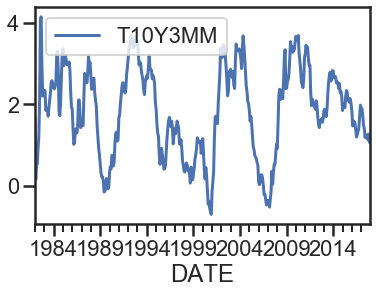

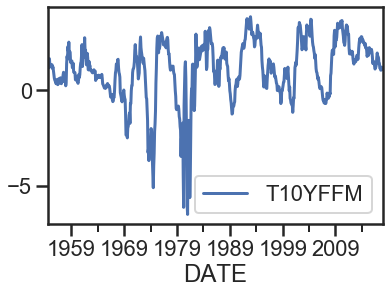

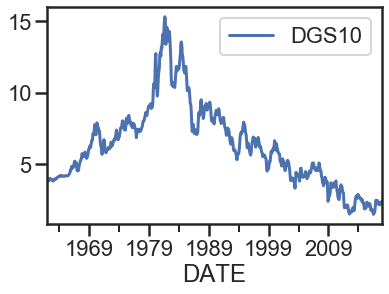

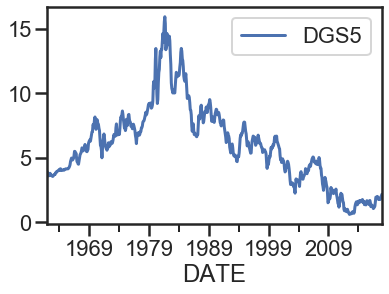

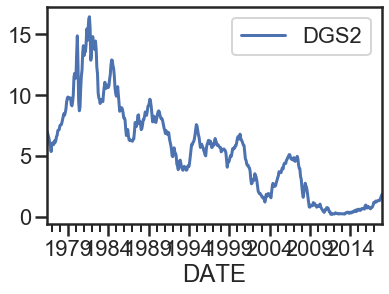

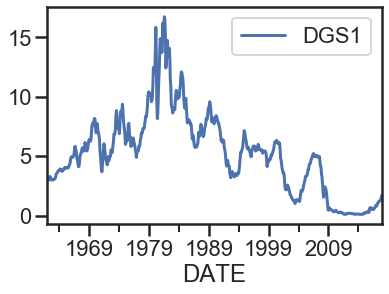

In [4]:
#
t10y3mm = web.DataReader("T10Y3MM", "fred", start, end).to_period('M')
t10y3mm.plot()
t10yffm = web.DataReader("T10YFFM", "fred", start, end).to_period('M')
t10yffm.plot()
dgs10 = web.DataReader("DGS10", "fred", start, end).resample('M').mean().to_period('M')
dgs10.plot()
dgs5 = web.DataReader("DGS5", "fred", start, end).resample('M').mean().to_period('M')
dgs5.plot()
dgs2 = web.DataReader("DGS2", "fred", start, end).resample('M').mean().to_period('M')
dgs2.plot()
dgs1 = web.DataReader("DGS1", "fred", start, end).resample('M').mean().to_period('M')
dgs1.plot()

In [5]:
frames = [usrec,t10y3mm,t10yffm,dgs1, dgs2, dgs5, dgs10  ]
data = pd.concat(frames,axis=1)
data.tail(10)

,USREC,T10Y3MM,T10YFFM,DGS1,DGS2,DGS5,DGS10
DATE,,,,,,,
2017-03,0,1.73000,1.69000,1.01043,1.31304,2.01348,2.48174
2017-04,0,1.49000,1.40000,1.04211,1.24105,1.82421,2.29737
2017-05,0,1.40000,1.39000,1.12273,1.30182,1.83682,2.30364
2017-06,0,1.19000,1.15000,1.20091,1.34227,1.77409,2.18682
2017-07,0,1.23000,1.17000,1.22350,1.37250,1.87200,2.31800
2017-08,0,1.18000,1.05000,1.22913,1.33522,1.77652,2.20913
2017-09,0,1.15000,1.05000,1.28000,1.38450,1.79750,2.20200
2017-10,0,1.27000,1.21000,1.39762,1.54952,1.98095,2.36000
2017-11,0,1.10000,1.19000,1.56000,1.69667,2.05000,2.35333


In [6]:
data.dropna()

,USREC,T10Y3MM,T10YFFM,DGS1,DGS2,DGS5,DGS10
DATE,,,,,,,
1982-01,1,1.67000,1.37000,14.31800,14.56800,14.64550,14.59400
1982-02,1,0.15000,-0.35000,14.73389,14.82333,14.54056,14.42556
1982-03,1,0.55000,-0.82000,13.94913,14.19435,13.97739,13.86130
1982-04,1,0.53000,-1.07000,13.97952,14.20238,14.00381,13.87190
1982-05,1,0.91000,-0.83000,13.34350,13.77700,13.75400,13.62250
...,...,...,...,...,...,...,...
2017-08,0,1.18000,1.05000,1.22913,1.33522,1.77652,2.20913
2017-09,0,1.15000,1.05000,1.28000,1.38450,1.79750,2.20200
2017-10,0,1.27000,1.21000,1.39762,1.54952,1.98095,2.36000


In [7]:
def plot_var(y1):
    fig0, ax0 = plt.subplots(figsize=(15,8))
    ax1 = ax0.twinx()
    ax = plt.gca()
    plt.grid(True)
    y1.plot(kind='line', stacked=False, ax=ax0, color='blue')
    data['USREC'].plot(kind='area', secondary_y=True, ax=ax1, alpha=.2, color='grey',label="Recession")
    ax0.legend(loc='upper left')
    plt.legend(loc='best')
    plt.ylim(ymin=0.0,ymax=0.8)
    plt.axis('off')
    plt.xlabel('Date')
    fig0.tight_layout()

In [8]:
t10y1ym = (dgs10['DGS10'] - dgs1['DGS1']).to_frame().rename(columns={0:'T10Y1YM'})
t5y2ym = (dgs5['DGS5'] - dgs2['DGS2']).to_frame().rename(columns={0:'T5Y2YM'})

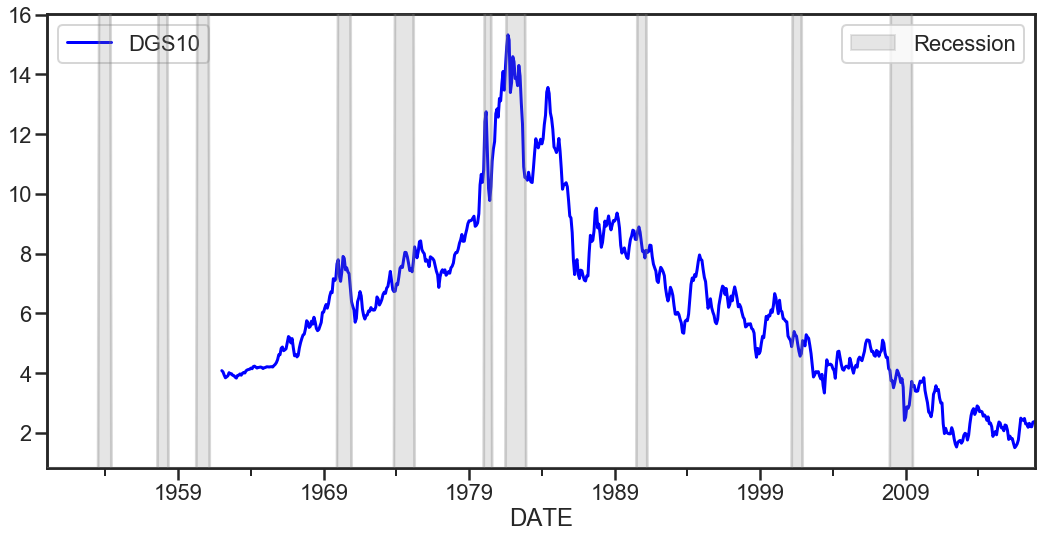

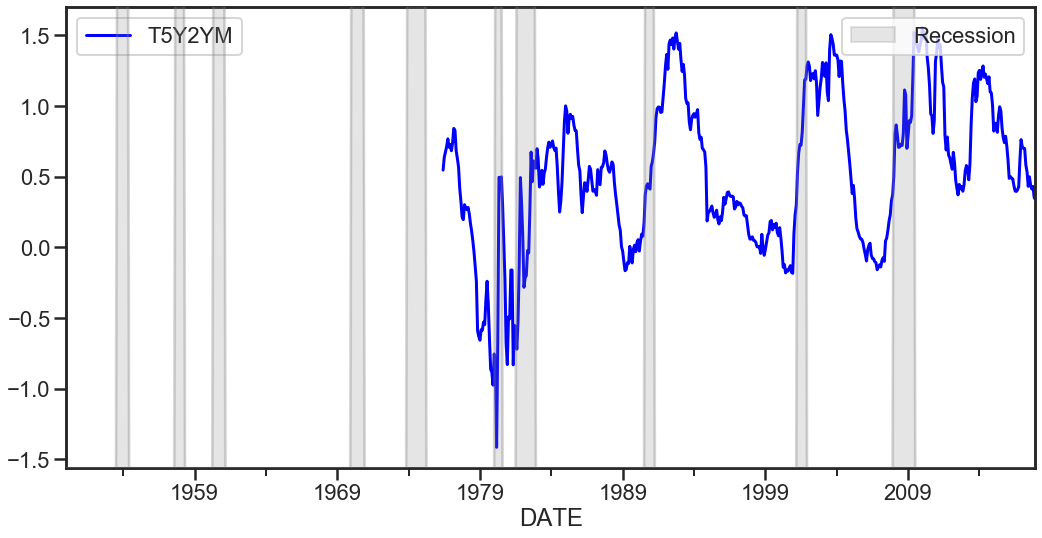

In [9]:
plot_var(dgs10)
plot_var(t5y2ym)

In [10]:
df=t10y1ym.copy()
df1=t10y1ym.copy()
for col in t10y1ym.columns:
    for l in range(3,25,3):
        df.loc[:,col+"_"+str(l)] = t10y1ym[col].shift(l)
print(df.columns)
print(len(df.columns))

Index(['T10Y1YM', 'T10Y1YM_3', 'T10Y1YM_6', 'T10Y1YM_9', 'T10Y1YM_12',
       'T10Y1YM_15', 'T10Y1YM_18', 'T10Y1YM_21', 'T10Y1YM_24'],
      dtype='object')
9


In [11]:
for k in range(3,25,3):
    df1.loc[:,'T10Y1YM'+"_PCHG_"+str(k)]=df.loc[:,'T10Y1YM'].pct_change(periods=k)

for k in range(6,25,3):
    df1.loc[:,'T10Y1YM_3'+"_PCHG_"+str(k)]=df.loc[:,'T10Y1YM_3'].pct_change(periods=k)

for k in range(9,25,3):
    df1.loc[:,'T10Y1YM_6'+"_PCHG_"+str(k)]=df.loc[:,'T10Y1YM_6'].pct_change(periods=k)

for k in range(12,25,3):
    df1.loc[:,'T10Y1YM_9'+"_PCHG_"+str(k)]=df.loc[:,'T10Y1YM_9'].pct_change(periods=k)

for k in range(15,25,3):
    df1.loc[:,'T10Y1YM_12'+"_PCHG_"+str(k)]=df.loc[:,'T10Y1YM_12'].pct_change(periods=k)
    
for k in range(18,25,3):
    df1.loc[:,'T10Y1YM_15'+"_PCHG_"+str(k)]=df.loc[:,'T10Y1YM_15'].pct_change(periods=k)
    
for k in range(21,25,3):
    df1.loc[:,'T10Y1YM_18'+"_PCHG_"+str(k)]=df.loc[:,'T10Y1YM_18'].pct_change(periods=k)
    
for k in range(24,25,3):
    df1.loc[:,'T10Y1YM_21'+"_PCHG_"+str(k)]=df.loc[:,'T10Y1YM_21'].pct_change(periods=k)

In [12]:
df1.tail()

,T10Y1YM,T10Y1YM_PCHG_3,T10Y1YM_PCHG_6,T10Y1YM_PCHG_9,T10Y1YM_PCHG_12,T10Y1YM_PCHG_15,T10Y1YM_PCHG_18,T10Y1YM_PCHG_21,T10Y1YM_PCHG_24,T10Y1YM_3_PCHG_6,T10Y1YM_3_PCHG_9,T10Y1YM_3_PCHG_12,T10Y1YM_3_PCHG_15,T10Y1YM_3_PCHG_18,T10Y1YM_3_PCHG_21,T10Y1YM_3_PCHG_24,T10Y1YM_6_PCHG_9,T10Y1YM_6_PCHG_12,T10Y1YM_6_PCHG_15,T10Y1YM_6_PCHG_18,T10Y1YM_6_PCHG_21,T10Y1YM_6_PCHG_24,T10Y1YM_9_PCHG_12,T10Y1YM_9_PCHG_15,T10Y1YM_9_PCHG_18,T10Y1YM_9_PCHG_21,T10Y1YM_9_PCHG_24,T10Y1YM_12_PCHG_15,T10Y1YM_12_PCHG_18,T10Y1YM_12_PCHG_21,T10Y1YM_12_PCHG_24,T10Y1YM_15_PCHG_18,T10Y1YM_15_PCHG_21,T10Y1YM_15_PCHG_24,T10Y1YM_18_PCHG_21,T10Y1YM_18_PCHG_24,T10Y1YM_21_PCHG_24
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08,0.98000,-0.17013,-0.38689,-0.30299,-0.00836,-0.19326,-0.21317,-0.45138,-0.45295,-0.16009,0.19494,-0.02787,-0.05186,-0.33891,-0.34080,-0.39642,0.31583,0.28336,-0.10519,-0.10774,-0.18302,-0.08717,-0.21291,-0.21515,-0.28137,-0.19705,-0.35832,-0.49488,-0.43562,-0.54897,-0.57271,-0.44560,-0.47478,-0.50667,-0.49419,-0.51960,-0.31212
2017-09,0.92200,-0.06482,-0.37335,-0.43286,-0.11102,-0.15554,-0.25206,-0.41979,-0.48764,-0.39355,-0.04940,-0.09700,-0.20022,-0.37958,-0.45213,-0.52786,0.34757,0.19354,-0.07412,-0.18239,-0.29541,-0.17762,0.02305,-0.09659,-0.22147,-0.09132,-0.18418,-0.50333,-0.42030,-0.47954,-0.57227,-0.45210,-0.54972,-0.56219,-0.50569,-0.52500,-0.42612
2017-10,0.96238,-0.12071,-0.23332,-0.40113,-0.12907,-0.02839,-0.22980,-0.37593,-0.46732,-0.31892,-0.00950,0.10500,-0.12407,-0.29026,-0.39419,-0.46023,0.26730,0.00459,-0.18601,-0.30520,-0.38095,-0.26220,0.04208,-0.11052,-0.20749,-0.05546,-0.04686,-0.45505,-0.35052,-0.34460,-0.49762,-0.41251,-0.54968,-0.59254,-0.48598,-0.51897,-0.43758
2017-11,0.79333,-0.19048,-0.32820,-0.50368,-0.43575,-0.19724,-0.34692,-0.36304,-0.55588,-0.38689,-0.30299,-0.00836,-0.19326,-0.21317,-0.45138,-0.45295,0.19494,-0.02787,-0.05186,-0.33891,-0.34080,-0.39642,0.28336,-0.10519,-0.10774,-0.18302,-0.08717,-0.21515,-0.28137,-0.19705,-0.35832,-0.43562,-0.54897,-0.57271,-0.47478,-0.50667,-0.51960
2017-12,0.70200,-0.23861,-0.28797,-0.52287,-0.56819,-0.32314,-0.35704,-0.43053,-0.55824,-0.37335,-0.43286,-0.11102,-0.15554,-0.25206,-0.41979,-0.48764,-0.04940,-0.09700,-0.20022,-0.37958,-0.45213,-0.52786,0.19354,-0.07412,-0.18239,-0.29541,-0.17762,-0.09659,-0.22147,-0.09132,-0.18418,-0.42030,-0.47954,-0.57227,-0.54972,-0.56219,-0.52500


In [13]:
df

,T10Y1YM,T10Y1YM_3,T10Y1YM_6,T10Y1YM_9,T10Y1YM_12,T10Y1YM_15,T10Y1YM_18,T10Y1YM_21,T10Y1YM_24
DATE,,,,,,,,,
1962-01,0.80364,nan,nan,nan,nan,nan,nan,nan,nan
1962-02,0.75556,nan,nan,nan,nan,nan,nan,nan,nan
1962-03,0.87227,nan,nan,nan,nan,nan,nan,nan,nan
1962-04,0.85550,0.80364,nan,nan,nan,nan,nan,nan,nan
1962-05,0.84773,0.75556,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...
2017-08,0.98000,1.18091,1.59842,1.40600,0.98826,1.21476,1.24550,1.78632,1.79143
2017-09,0.92200,0.98591,1.47130,1.62571,1.03714,1.09182,1.23273,1.58909,1.79952
2017-10,0.96238,1.09450,1.25526,1.60700,1.10500,0.99050,1.24952,1.54211,1.80667


In [14]:
values = {'USREC':0.0}
#data.GDP = data.GDP.interpolate(method='spline', order=2)
usrec.fillna(value=values,inplace=True)
spread_frame = [usrec,df,df1]
spread_model_data = pd.concat(spread_frame,axis=1)
spread_model_data=spread_model_data.dropna()
spread_model_data

,USREC,T10Y1YM,T10Y1YM_3,T10Y1YM_6,T10Y1YM_9,T10Y1YM_12,T10Y1YM_15,T10Y1YM_18,T10Y1YM_21,T10Y1YM_24,T10Y1YM,T10Y1YM_PCHG_3,T10Y1YM_PCHG_6,T10Y1YM_PCHG_9,T10Y1YM_PCHG_12,T10Y1YM_PCHG_15,T10Y1YM_PCHG_18,T10Y1YM_PCHG_21,T10Y1YM_PCHG_24,T10Y1YM_3_PCHG_6,T10Y1YM_3_PCHG_9,T10Y1YM_3_PCHG_12,T10Y1YM_3_PCHG_15,T10Y1YM_3_PCHG_18,T10Y1YM_3_PCHG_21,T10Y1YM_3_PCHG_24,T10Y1YM_6_PCHG_9,T10Y1YM_6_PCHG_12,T10Y1YM_6_PCHG_15,T10Y1YM_6_PCHG_18,T10Y1YM_6_PCHG_21,T10Y1YM_6_PCHG_24,T10Y1YM_9_PCHG_12,T10Y1YM_9_PCHG_15,T10Y1YM_9_PCHG_18,T10Y1YM_9_PCHG_21,T10Y1YM_9_PCHG_24,T10Y1YM_12_PCHG_15,T10Y1YM_12_PCHG_18,T10Y1YM_12_PCHG_21,T10Y1YM_12_PCHG_24,T10Y1YM_15_PCHG_18,T10Y1YM_15_PCHG_21,T10Y1YM_15_PCHG_24,T10Y1YM_18_PCHG_21,T10Y1YM_18_PCHG_24,T10Y1YM_21_PCHG_24
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1965-10,0,0.05150,0.22000,0.16714,0.24750,0.32429,0.47091,0.32227,0.37455,0.46652,0.05150,-0.76591,-0.69188,-0.79192,-0.84119,-0.89064,-0.84020,-0.86250,-0.88961,-0.11111,-0.32159,-0.53282,-0.31735,-0.41262,-0.52842,-0.59667,-0.64506,-0.48136,-0.55374,-0.64173,-0.69357,-0.80478,-0.33920,-0.46948,-0.54625,-0.71093,-0.68868,-0.40548,-0.62125,-0.59209,-0.65881,-0.40766,-0.50454,-0.34940,-0.55475,-0.62329,-0.53394
1965-11,0,0.07421,0.18364,0.18100,0.18389,0.24500,0.45000,0.36100,0.36333,0.38118,0.07421,-0.59588,-0.59000,-0.59644,-0.69710,-0.83509,-0.79443,-0.79575,-0.80531,-0.00137,-0.25046,-0.59192,-0.49131,-0.49458,-0.51824,-0.60815,-0.59778,-0.49861,-0.50183,-0.52515,-0.61377,-0.77729,-0.49388,-0.51758,-0.60761,-0.77374,-0.79805,-0.47721,-0.69855,-0.73093,-0.73185,-0.50580,-0.50749,-0.42049,-0.53511,-0.57416,-0.51912
1965-12,0,-0.10182,0.08571,0.22364,0.14696,0.15773,0.36333,0.33682,0.30667,0.31714,-0.10182,-2.18788,-1.45528,-1.69285,-1.64553,-1.28023,-1.30229,-1.33202,-1.32105,-0.41674,-0.45657,-0.76409,-0.74552,-0.72050,-0.72973,-0.82976,-0.38449,-0.33603,-0.27075,-0.29484,-0.55584,-0.71905,-0.52079,-0.53662,-0.70813,-0.81538,-0.83619,-0.68674,-0.80185,-0.82419,-0.81628,-0.59501,-0.57678,-0.60439,-0.63326,-0.61767,-0.64843
1966-01,0,-0.26429,0.05150,0.22000,0.16714,0.24750,0.32429,0.47091,0.32227,0.37455,-0.26429,-6.13176,-2.20130,-2.58120,-2.06782,-1.81498,-1.56122,-1.82007,-1.70562,-0.69188,-0.79192,-0.84119,-0.89064,-0.84020,-0.86250,-0.88961,-0.32159,-0.53282,-0.31735,-0.41262,-0.52842,-0.59667,-0.48136,-0.55374,-0.64173,-0.69357,-0.80478,-0.46948,-0.54625,-0.71093,-0.68868,-0.62125,-0.59209,-0.65881,-0.50454,-0.34940,-0.62329
1966-02,0,-0.11000,0.07421,0.18364,0.18100,0.18389,0.24500,0.45000,0.36100,0.36333,-0.11000,-2.48227,-1.59901,-1.60773,-1.59819,-1.44898,-1.24444,-1.30471,-1.30275,-0.59000,-0.59644,-0.69710,-0.83509,-0.79443,-0.79575,-0.80531,-0.25046,-0.59192,-0.49131,-0.49458,-0.51824,-0.60815,-0.49861,-0.50183,-0.52515,-0.61377,-0.77729,-0.51758,-0.60761,-0.77374,-0.79805,-0.69855,-0.73093,-0.73185,-0.50749,-0.42049,-0.57416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08,0,0.98000,1.18091,1.59842,1.40600,0.98826,1.21476,1.24550,1.78632,1.79143,0.98000,-0.17013,-0.38689,-0.30299,-0.00836,-0.19326,-0.21317,-0.45138,-0.45295,-0.16009,0.19494,-0.02787,-0.05186,-0.33891,-0.34080,-0.39642,0.31583,0.28336,-0.10519,-0.10774,-0.18302,-0.08717,-0.21291,-0.21515,-0.28137,-0.19705,-0.35832,-0.49488,-0.43562,-0.54897,-0.57271,-0.44560,-0.47478,-0.50667,-0.49419,-0.51960,-0.31212
2017-09,0,0.92200,0.98591,1.47130,1.62571,1.03714,1.09182,1.23273,1.58909,1.79952,0.92200,-0.06482,-0.37335,-0.43286,-0.11102,-0.15554,-0.25206,-0.41979,-0.48764,-0.39355,-0.04940,-0.09700,-0.20022,-0.37958,-0.45213,-0.52786,0.34757,0.19354,-0.07412,-0.18239,-0.29541,-0.17762,0.02305,-0.09659,-0.22147,-0.09132,-0.18418,-0.50333,-0.42030,-0.47954,-0.57227,-0.45210,-0.54972,-0.56219,-0.50569,-0.52500,-0.42612
2017-10,0,0.96238,1.09450,1.25526,1.60700,1.10500,0.99050,1.24952,1.54211,1.80667,0.96238,-0.12071,-0.23332,-0.401

In [15]:
df1=spread_model_data.copy()
train_cols = ['T10Y1YM_12','T10Y1YM_15','T10Y1YM_18','T10Y1YM_21','T10Y1YM_24','T10Y1YM_12_PCHG_15','T10Y1YM_12_PCHG_18','T10Y1YM_12_PCHG_21','T10Y1YM_12_PCHG_24',
             'T10Y1YM_15_PCHG_18','T10Y1YM_15_PCHG_21','T10Y1YM_15_PCHG_24',
             'T10Y1YM_18_PCHG_21','T10Y1YM_18_PCHG_24','T10Y1YM_21_PCHG_24']
train_cols

['T10Y1YM_12',
 'T10Y1YM_15',
 'T10Y1YM_18',
 'T10Y1YM_21',
 'T10Y1YM_24',
 'T10Y1YM_12_PCHG_15',
 'T10Y1YM_12_PCHG_18',
 'T10Y1YM_12_PCHG_21',
 'T10Y1YM_12_PCHG_24',
 'T10Y1YM_15_PCHG_18',
 'T10Y1YM_15_PCHG_21',
 'T10Y1YM_15_PCHG_24',
 'T10Y1YM_18_PCHG_21',
 'T10Y1YM_18_PCHG_24',
 'T10Y1YM_21_PCHG_24']

In [16]:
df1

,USREC,T10Y1YM,T10Y1YM_3,T10Y1YM_6,T10Y1YM_9,T10Y1YM_12,T10Y1YM_15,T10Y1YM_18,T10Y1YM_21,T10Y1YM_24,T10Y1YM,T10Y1YM_PCHG_3,T10Y1YM_PCHG_6,T10Y1YM_PCHG_9,T10Y1YM_PCHG_12,T10Y1YM_PCHG_15,T10Y1YM_PCHG_18,T10Y1YM_PCHG_21,T10Y1YM_PCHG_24,T10Y1YM_3_PCHG_6,T10Y1YM_3_PCHG_9,T10Y1YM_3_PCHG_12,T10Y1YM_3_PCHG_15,T10Y1YM_3_PCHG_18,T10Y1YM_3_PCHG_21,T10Y1YM_3_PCHG_24,T10Y1YM_6_PCHG_9,T10Y1YM_6_PCHG_12,T10Y1YM_6_PCHG_15,T10Y1YM_6_PCHG_18,T10Y1YM_6_PCHG_21,T10Y1YM_6_PCHG_24,T10Y1YM_9_PCHG_12,T10Y1YM_9_PCHG_15,T10Y1YM_9_PCHG_18,T10Y1YM_9_PCHG_21,T10Y1YM_9_PCHG_24,T10Y1YM_12_PCHG_15,T10Y1YM_12_PCHG_18,T10Y1YM_12_PCHG_21,T10Y1YM_12_PCHG_24,T10Y1YM_15_PCHG_18,T10Y1YM_15_PCHG_21,T10Y1YM_15_PCHG_24,T10Y1YM_18_PCHG_21,T10Y1YM_18_PCHG_24,T10Y1YM_21_PCHG_24
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1965-10,0,0.05150,0.22000,0.16714,0.24750,0.32429,0.47091,0.32227,0.37455,0.46652,0.05150,-0.76591,-0.69188,-0.79192,-0.84119,-0.89064,-0.84020,-0.86250,-0.88961,-0.11111,-0.32159,-0.53282,-0.31735,-0.41262,-0.52842,-0.59667,-0.64506,-0.48136,-0.55374,-0.64173,-0.69357,-0.80478,-0.33920,-0.46948,-0.54625,-0.71093,-0.68868,-0.40548,-0.62125,-0.59209,-0.65881,-0.40766,-0.50454,-0.34940,-0.55475,-0.62329,-0.53394
1965-11,0,0.07421,0.18364,0.18100,0.18389,0.24500,0.45000,0.36100,0.36333,0.38118,0.07421,-0.59588,-0.59000,-0.59644,-0.69710,-0.83509,-0.79443,-0.79575,-0.80531,-0.00137,-0.25046,-0.59192,-0.49131,-0.49458,-0.51824,-0.60815,-0.59778,-0.49861,-0.50183,-0.52515,-0.61377,-0.77729,-0.49388,-0.51758,-0.60761,-0.77374,-0.79805,-0.47721,-0.69855,-0.73093,-0.73185,-0.50580,-0.50749,-0.42049,-0.53511,-0.57416,-0.51912
1965-12,0,-0.10182,0.08571,0.22364,0.14696,0.15773,0.36333,0.33682,0.30667,0.31714,-0.10182,-2.18788,-1.45528,-1.69285,-1.64553,-1.28023,-1.30229,-1.33202,-1.32105,-0.41674,-0.45657,-0.76409,-0.74552,-0.72050,-0.72973,-0.82976,-0.38449,-0.33603,-0.27075,-0.29484,-0.55584,-0.71905,-0.52079,-0.53662,-0.70813,-0.81538,-0.83619,-0.68674,-0.80185,-0.82419,-0.81628,-0.59501,-0.57678,-0.60439,-0.63326,-0.61767,-0.64843
1966-01,0,-0.26429,0.05150,0.22000,0.16714,0.24750,0.32429,0.47091,0.32227,0.37455,-0.26429,-6.13176,-2.20130,-2.58120,-2.06782,-1.81498,-1.56122,-1.82007,-1.70562,-0.69188,-0.79192,-0.84119,-0.89064,-0.84020,-0.86250,-0.88961,-0.32159,-0.53282,-0.31735,-0.41262,-0.52842,-0.59667,-0.48136,-0.55374,-0.64173,-0.69357,-0.80478,-0.46948,-0.54625,-0.71093,-0.68868,-0.62125,-0.59209,-0.65881,-0.50454,-0.34940,-0.62329
1966-02,0,-0.11000,0.07421,0.18364,0.18100,0.18389,0.24500,0.45000,0.36100,0.36333,-0.11000,-2.48227,-1.59901,-1.60773,-1.59819,-1.44898,-1.24444,-1.30471,-1.30275,-0.59000,-0.59644,-0.69710,-0.83509,-0.79443,-0.79575,-0.80531,-0.25046,-0.59192,-0.49131,-0.49458,-0.51824,-0.60815,-0.49861,-0.50183,-0.52515,-0.61377,-0.77729,-0.51758,-0.60761,-0.77374,-0.79805,-0.69855,-0.73093,-0.73185,-0.50749,-0.42049,-0.57416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08,0,0.98000,1.18091,1.59842,1.40600,0.98826,1.21476,1.24550,1.78632,1.79143,0.98000,-0.17013,-0.38689,-0.30299,-0.00836,-0.19326,-0.21317,-0.45138,-0.45295,-0.16009,0.19494,-0.02787,-0.05186,-0.33891,-0.34080,-0.39642,0.31583,0.28336,-0.10519,-0.10774,-0.18302,-0.08717,-0.21291,-0.21515,-0.28137,-0.19705,-0.35832,-0.49488,-0.43562,-0.54897,-0.57271,-0.44560,-0.47478,-0.50667,-0.49419,-0.51960,-0.31212
2017-09,0,0.92200,0.98591,1.47130,1.62571,1.03714,1.09182,1.23273,1.58909,1.79952,0.92200,-0.06482,-0.37335,-0.43286,-0.11102,-0.15554,-0.25206,-0.41979,-0.48764,-0.39355,-0.04940,-0.09700,-0.20022,-0.37958,-0.45213,-0.52786,0.34757,0.19354,-0.07412,-0.18239,-0.29541,-0.17762,0.02305,-0.09659,-0.22147,-0.09132,-0.18418,-0.50333,-0.42030,-0.47954,-0.57227,-0.45210,-0.54972,-0.56219,-0.50569,-0.52500,-0.42612
2017-10,0,0.96238,1.09450,1.25526,1.60700,1.10500,0.99050,1.24952,1.54211,1.80667,0.96238,-0.12071,-0.23332,-0.401

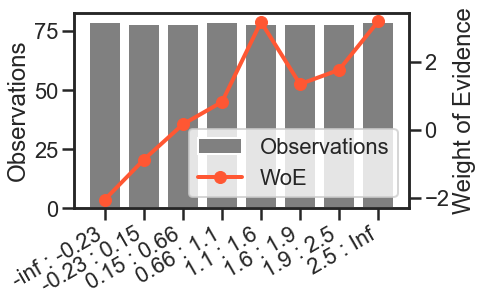

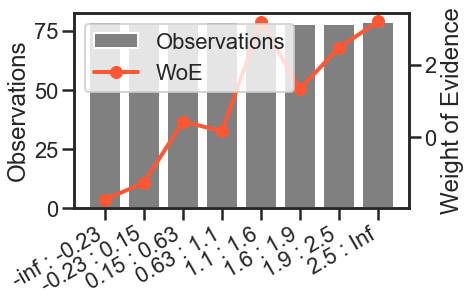

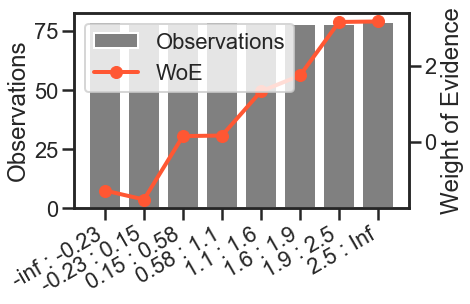

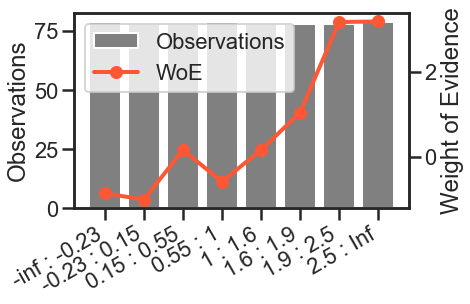

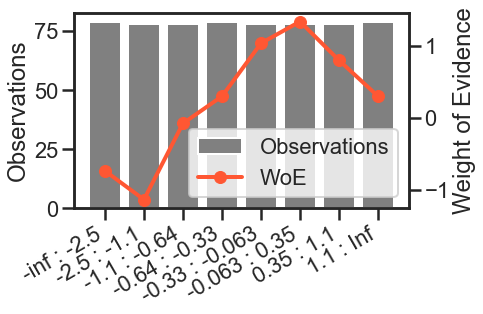

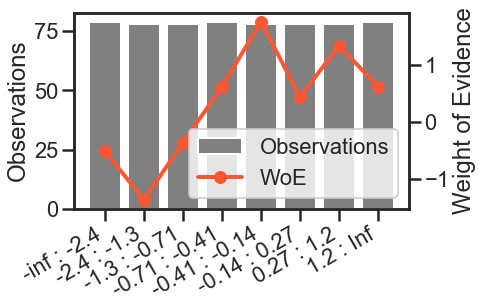

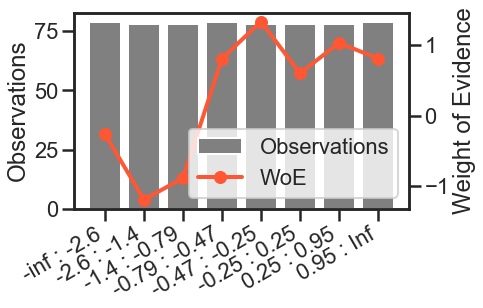

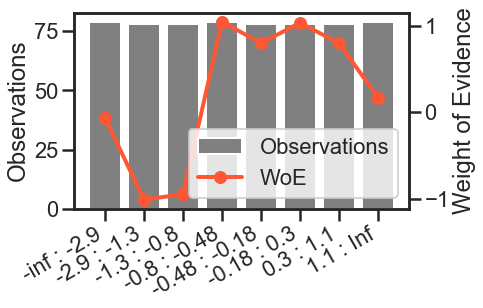

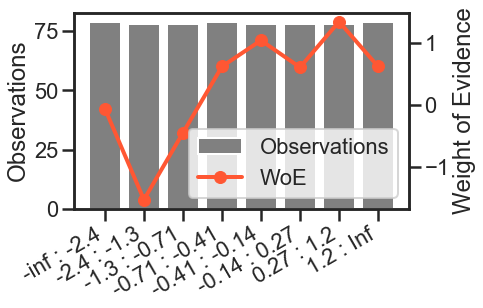

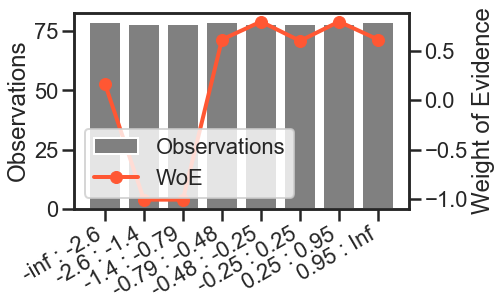

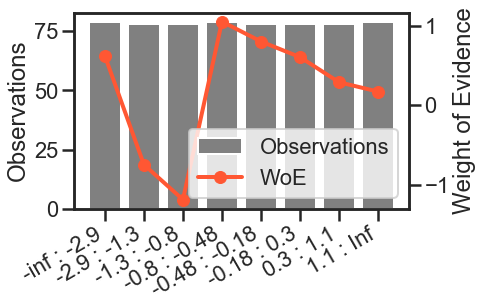

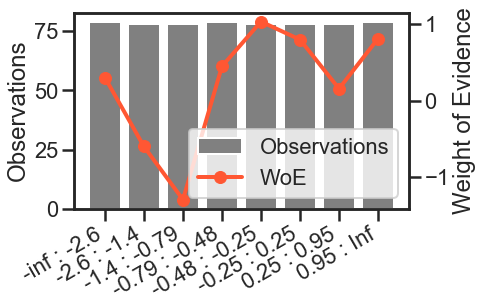

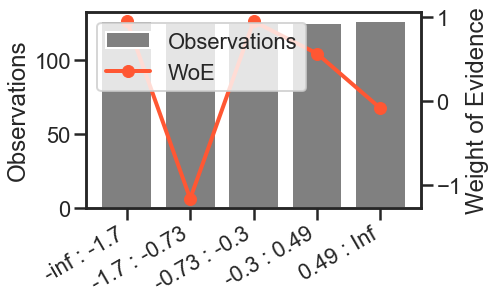

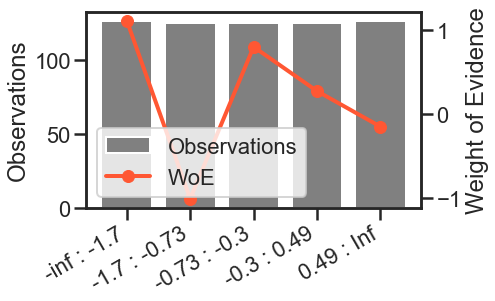

In [17]:

# Initialize WoE object
t_type_ = 'b'
woe_def = WoE()
woe = WoE(7, 30, spec_values={0: '0', 1: '1'}, v_type='b', t_type=t_type_)

a=woe.fit(spread_model_data['T10Y1YM_12'], spread_model_data['USREC'])
fig=woe.plot()

woe.fit(spread_model_data['T10Y1YM_15'], spread_model_data['USREC'])
fig=woe.plot()

woe.fit(spread_model_data['T10Y1YM_18'], spread_model_data['USREC'])
fig=woe.plot()

woe.fit(spread_model_data['T10Y1YM_24'], spread_model_data['USREC'])
fig=woe.plot()

woe.fit(spread_model_data['T10Y1YM_12_PCHG_15'], spread_model_data['USREC'])
fig = woe.plot()

woe.fit(spread_model_data['T10Y1YM_12_PCHG_18'], spread_model_data['USREC'])
fig = woe.plot()

woe.fit(spread_model_data['T10Y1YM_12_PCHG_21'], spread_model_data['USREC'])
fig = woe.plot()

woe.fit(spread_model_data['T10Y1YM_12_PCHG_24'], spread_model_data['USREC'])
fig = woe.plot()

woe.fit(spread_model_data['T10Y1YM_15_PCHG_18'], spread_model_data['USREC'])
fig = woe.plot()

woe.fit(spread_model_data['T10Y1YM_15_PCHG_21'], spread_model_data['USREC'])
fig = woe.plot()

woe.fit(spread_model_data['T10Y1YM_15_PCHG_24'], spread_model_data['USREC'])
fig = woe.plot()

woe.fit(spread_model_data['T10Y1YM_18_PCHG_21'], spread_model_data['USREC'])
fig = woe.plot()

woe = WoE(4, 30, spec_values={0: '0', 1: '1'}, v_type='b', t_type=t_type_)

woe.fit(spread_model_data['T10Y1YM_18_PCHG_24'], spread_model_data['USREC'])
fig = woe.plot()

woe.fit(spread_model_data['T10Y1YM_21_PCHG_24'], spread_model_data['USREC'])
fig = woe.plot()

In [18]:
df1 = df1.loc[:,~df1.columns.duplicated()]
df1.describe()

,USREC,T10Y1YM,T10Y1YM_3,T10Y1YM_6,T10Y1YM_9,T10Y1YM_12,T10Y1YM_15,T10Y1YM_18,T10Y1YM_21,T10Y1YM_24,T10Y1YM_PCHG_3,T10Y1YM_PCHG_6,T10Y1YM_PCHG_9,T10Y1YM_PCHG_12,T10Y1YM_PCHG_15,T10Y1YM_PCHG_18,T10Y1YM_PCHG_21,T10Y1YM_PCHG_24,T10Y1YM_3_PCHG_6,T10Y1YM_3_PCHG_9,T10Y1YM_3_PCHG_12,T10Y1YM_3_PCHG_15,T10Y1YM_3_PCHG_18,T10Y1YM_3_PCHG_21,T10Y1YM_3_PCHG_24,T10Y1YM_6_PCHG_9,T10Y1YM_6_PCHG_12,T10Y1YM_6_PCHG_15,T10Y1YM_6_PCHG_18,T10Y1YM_6_PCHG_21,T10Y1YM_6_PCHG_24,T10Y1YM_9_PCHG_12,T10Y1YM_9_PCHG_15,T10Y1YM_9_PCHG_18,T10Y1YM_9_PCHG_21,T10Y1YM_9_PCHG_24,T10Y1YM_12_PCHG_15,T10Y1YM_12_PCHG_18,T10Y1YM_12_PCHG_21,T10Y1YM_12_PCHG_24,T10Y1YM_15_PCHG_18,T10Y1YM_15_PCHG_21,T10Y1YM_15_PCHG_24,T10Y1YM_18_PCHG_21,T10Y1YM_18_PCHG_24,T10Y1YM_21_PCHG_24
count,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000,627.00000
mean,0.13238,1.08075,1.07761,1.07374,1.06920,1.06290,1.05836,1.05517,1.05117,1.04661,0.27319,0.16795,-0.10238,0.00807,-0.30434,-0.33313,-0.56163,-0.72118,0.16846,-0.10175,0.00687,-0.30595,-0.33423,-0.56260,-0.72190,-0.10315,0.00479,-0.30731,-0.33536,-0.56355,-0.72334,0.00282,-0.30904,-0.33670,-0.56535,-0.72515,-0.31108,-0.33929,-0.56792,-0.72817,-0.34033,-0.56945,-0.72871,-0.56968,-0.72883,-0.72901
std,0.33917,1.17561,1.17716,1.17873,1.18027,1.18116,1.18167,1.18271,1.18367,1.18435,7.12035,4.43180,6.67077,8.58989,8.88782,8.79989,10.15416,12.65192,4.43177,6.67075,8.58996,8.88784,8.79991,10.15416,12.65192,6.67080,8.59001,8.88784,8.79992,10.15416,12.65190,8.59007,8.88784,8.79994,10.15416,12.65188,8.88785,8.79997,10.15413,12.65181,8.79998,10.15410,12.65180,10.15410,12.65179,12.65179
min,0.00000,-3.06857,-3.06857,-3.06857,-3.06857,-3.06857,-3.06857,-3.06857,-3.06857,-3.06857,-25.45617,-18.84621,-73.67687,-57.80869,-79.46890,-101.95238,-96.96491,-116.51852,-18.84621,-73.67687,-57.80869,-79.46890,-101.95238,-96.96491,-116.51852,-73.67687,-57.80869,-79.46890,-101.95238,-96.96491,-116.51852,-57.80869,-79.46890,-101.95238,-96.96491,-116.51852,-79.46890,-101.95238,-96.96491,-116.51852,-101.95238,-96.96491,-116.51852,-96.96491,-116.51852,-116.51852
25%,0.00000,0.15262,0.14947,0.14947,0.14795,0.14795,0.14795,0.14795,0.14795,0.14795,-0.28454,-0.53042,-0.70974,-0.97237,-1.11453,-1.26151,-1.38302,-1.26757,-0.53042,-0.70974,-0.97237,-1.11453,-1.26151,-1.38302,-1.26757,-0.70974,-0.97237,-1.11453,-1.26151,-1.38302,-1.26757,-0.97237,-1.11453,-1.26151,-1.38302,-1.26757,-1.11453,-1.26151,-1.38302,-1.26757,-1.26151,-1.38302,-1.26757,-1.38302,-1.26757,-1.26757
50%,0.00000,1.13000,1.13000,1.13000,1.10200,1.09105,1.06714,1.06714,1.03286,1.02450,-0.06276,-0.10707,-0.16936,-0.22403,-0.32135,-0.37635,-0.44088,-0.46242,-0.10697,-0.16936,-0.22529,-0.32277,-0.39040,-0.44849,-0.46242,-0.16954,-0.23262,-0.32570,-0.40036,-0.45573,-0.46880,-0.23694,-0.32936,-0.40249,-0.46548,-0.47183,-0.33305,-0.41262,-0.47498,-0.47875,-0.41428,-0.48312,-0.47875,-0.48366,-0.47875,-0.47875
75%,0.00000,1.90233,1.90233,1.90233,1.90233,1.90233,1.90233,1.90233,1.90233,1.90233,0.16509,0.34599,0.34077,0.28528,0.34839,0.27185,0.25033,0.29968,0.34599,0.34077,0.28528,0.34839,0.27185,0.25033,0.29968,0.34077,0.28528,0.34839,0.27185,0.25033,0.29968,0.28528,0.34839,0.27185,0.25033,0.29968,0.34839,0.27185,0.25033,0.29968,0.27185,0.25033,0.29968,0.25033,0.29968,0.29968
max,1.00000,3.40182,3.40182,3.40182,3.40182,3.40182,3.40182,3.40182,3.40182,3.40182,157.41919,64.34783,106.86364,108.50700,95.52595,107.19091,117.03636,130.61818,64.34783,106.86364,108.50700,95.52595,107.19091,117.03636,130.61818,106.86364,108.50700,95.52595,107.19091,117.03636,130.61818,108.50700,95.52595,107.19091,117.03636,130.61818,95.52595,107.190

In [19]:
probit = sm.Probit(df1['USREC'], df1[train_cols])

probit_model = probit.fit(method='newton',maxiter=100)

Optimization terminated successfully.
         Current function value: 0.322788
         Iterations 7


In [20]:
print(probit_model.summary())

                          Probit Regression Results                           
Dep. Variable:                  USREC   No. Observations:                  627
Model:                         Probit   Df Residuals:                      612
Method:                           MLE   Df Model:                           14
Date:                Sun, 03 Jan 2021   Pseudo R-squ.:                  0.1742
Time:                        20:03:41   Log-Likelihood:                -202.39
converged:                       True   LL-Null:                       -245.08
Covariance Type:            nonrobust   LLR p-value:                 2.802e-12
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
T10Y1YM_12            -0.5307      0.115     -4.622      0.000      -0.756      -0.306
T10Y1YM_15            -0.1462      0.153     -0.958      0.338      -0.445       0.153
T10Y1YM_18          

In [21]:
usrec_pred = probit_model.predict(spread_model_data[train_cols])
print(usrec_pred.tail())

DATE
2017-08   0.06377
2017-09   0.06334
2017-10   0.06020
2017-11   0.04562
2017-12   0.04154
Freq: M, dtype: float64


In [23]:
usrec_pred = probit_model.predict(spread_model_data[train_cols]).to_frame().rename(columns={0:'PRED_USREC'})
pred_act = [usrec,usrec_pred]
pred_act_df = pd.concat(pred_act,axis=1)
usrec_pred_act = pred_act_df['1965-10':'2017-12']
usrec_pred_act

,USREC,PRED_USREC
DATE,,
1965-10,0,0.31637
1965-11,0,0.33429
1965-12,0,0.36189
1966-01,0,0.32935
1966-02,0,0.34893
...,...,...
2017-08,0,0.06377
2017-09,0,0.06334
2017-10,0,0.06020


In [24]:
def plot_var1(y1,y2):
    fig0, ax0 = plt.subplots(figsize=(15,8))
    ax1 = ax0.twinx()
    ax = plt.gca()
    plt.grid(True)
    y1.plot(kind='line', stacked=False, ax=ax0, color='blue')
    y2.plot(kind='area', secondary_y=True, ax=ax1, alpha=.2, color='grey',label="Recession")
    ax0.legend(loc='upper left')
    plt.legend(loc='best')
    plt.ylim(ymin=0.0,ymax=0.8)
    plt.axis('off')
    plt.xlabel('Date')
    fig0.tight_layout()

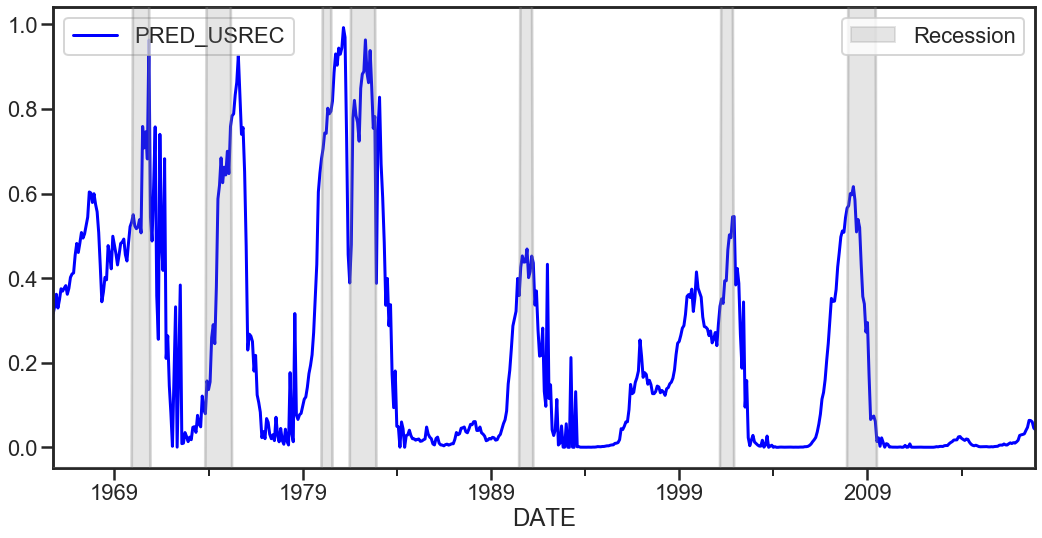

In [25]:
plot_var1(usrec_pred_act['PRED_USREC'],usrec_pred_act['USREC'])

In [26]:
train_cols = spread_model_data[['T10Y1YM_12','T10Y1YM_18','T10Y1YM_24','T10Y1YM_18_PCHG_24','T10Y1YM_21_PCHG_24']].columns
train_cols

Index(['T10Y1YM_12', 'T10Y1YM_18', 'T10Y1YM_24', 'T10Y1YM_18_PCHG_24',
       'T10Y1YM_21_PCHG_24'],
      dtype='object')

In [27]:
probit = sm.Probit(spread_model_data['USREC'], spread_model_data[train_cols])
probit_model = probit.fit(method='newton')
print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.327155
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:                  USREC   No. Observations:                  627
Model:                         Probit   Df Residuals:                      622
Method:                           MLE   Df Model:                            4
Date:                Sun, 03 Jan 2021   Pseudo R-squ.:                  0.1630
Time:                        20:16:03   Log-Likelihood:                -205.13
converged:                       True   LL-Null:                       -245.08
Covariance Type:            nonrobust   LLR p-value:                 1.820e-16
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
T10Y1YM_12            -0.6076      0.090     -6.777      0.000      -0.783      -0.432
T10Y1

In [28]:
usrec_pred = probit_model.predict(spread_model_data[train_cols]).to_frame().rename(columns={0:'PRED_USREC1'})

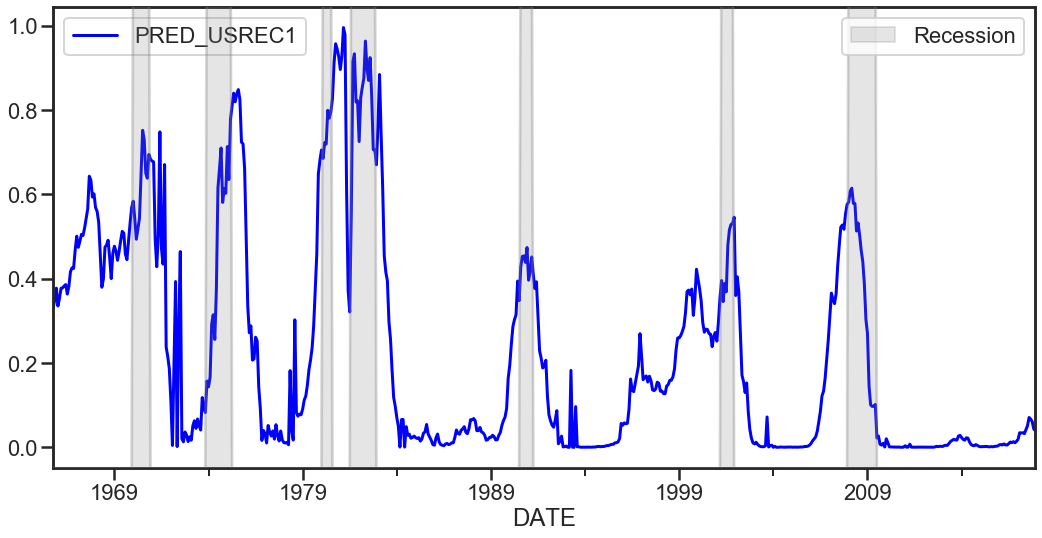

In [29]:
pred_act = [usrec,usrec_pred]
pred_act_df = pd.concat(pred_act,axis=1)
usrec_pred_act = pred_act_df['1965-10':'2017-12']
#pred_act_df.plot()
#plt.show()
plot_var1(usrec_pred_act['PRED_USREC1'],usrec_pred_act['USREC'])

In [30]:
start1 = pd.datetime(1965, 10, 1)

end1 = pd.datetime(2018, 12, 31)

rng = pd.date_range(start1, end1,freq='M').to_period('M')
rng

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


PeriodIndex(['1965-10', '1965-11', '1965-12', '1966-01', '1966-02', '1966-03',
             '1966-04', '1966-05', '1966-06', '1966-07',
             ...
             '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08',
             '2018-09', '2018-10', '2018-11', '2018-12'],
            dtype='period[M]', length=639, freq='M')

In [31]:
df1 = df1.loc[:,~df1.columns.duplicated()]
df1['shifted_index']=df1.index.shift(12)

In [32]:
df2=df1.copy()

In [33]:
df2=df2.tail(12)
df2

,USREC,T10Y1YM,T10Y1YM_3,T10Y1YM_6,T10Y1YM_9,T10Y1YM_12,T10Y1YM_15,T10Y1YM_18,T10Y1YM_21,T10Y1YM_24,T10Y1YM_PCHG_3,T10Y1YM_PCHG_6,T10Y1YM_PCHG_9,T10Y1YM_PCHG_12,T10Y1YM_PCHG_15,T10Y1YM_PCHG_18,T10Y1YM_PCHG_21,T10Y1YM_PCHG_24,T10Y1YM_3_PCHG_6,T10Y1YM_3_PCHG_9,T10Y1YM_3_PCHG_12,T10Y1YM_3_PCHG_15,T10Y1YM_3_PCHG_18,T10Y1YM_3_PCHG_21,T10Y1YM_3_PCHG_24,T10Y1YM_6_PCHG_9,T10Y1YM_6_PCHG_12,T10Y1YM_6_PCHG_15,T10Y1YM_6_PCHG_18,T10Y1YM_6_PCHG_21,T10Y1YM_6_PCHG_24,T10Y1YM_9_PCHG_12,T10Y1YM_9_PCHG_15,T10Y1YM_9_PCHG_18,T10Y1YM_9_PCHG_21,T10Y1YM_9_PCHG_24,T10Y1YM_12_PCHG_15,T10Y1YM_12_PCHG_18,T10Y1YM_12_PCHG_21,T10Y1YM_12_PCHG_24,T10Y1YM_15_PCHG_18,T10Y1YM_15_PCHG_21,T10Y1YM_15_PCHG_24,T10Y1YM_18_PCHG_21,T10Y1YM_18_PCHG_24,T10Y1YM_21_PCHG_24,shifted_index
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01,0,1.60700,1.10500,0.99050,1.24952,1.54211,1.80667,2.02773,1.70136,1.68600,0.45430,0.62241,0.28609,0.04208,-0.11052,-0.20749,-0.05546,-0.04686,-0.11566,-0.28345,-0.38838,-0.45505,-0.35052,-0.34460,-0.49762,-0.45175,-0.51152,-0.41782,-0.41251,-0.54968,-0.59254,-0.26558,-0.25888,-0.43192,-0.48598,-0.51897,-0.29890,-0.36563,-0.40634,-0.43758,-0.30449,-0.34109,-0.27575,-0.18714,-0.17587,0.04088,2018-01
2017-02,0,1.59842,1.40600,0.98826,1.21476,1.24550,1.78632,1.79143,1.95650,1.75105,0.13686,0.61741,0.31583,0.28336,-0.10519,-0.10774,-0.18302,-0.08717,0.15743,0.12886,-0.21291,-0.21515,-0.28137,-0.19705,-0.35832,-0.44676,-0.44834,-0.49488,-0.43562,-0.54897,-0.57271,-0.37911,-0.30627,-0.44560,-0.47478,-0.50667,-0.43157,-0.46149,-0.49419,-0.51960,-0.27456,-0.31100,-0.31212,-0.31015,-0.31375,0.08121,2018-02
2017-03,0,1.47130,1.62571,1.03714,1.09182,1.23273,1.58909,1.79952,2.08818,1.78909,-0.09498,0.41861,0.34757,0.19354,-0.07412,-0.18239,-0.29541,-0.17762,0.48900,0.31879,0.02305,-0.09659,-0.22147,-0.09132,-0.18418,-0.34734,-0.42366,-0.50333,-0.42030,-0.47954,-0.57227,-0.47714,-0.38974,-0.45210,-0.54972,-0.56219,-0.38139,-0.49161,-0.50569,-0.52500,-0.36279,-0.38769,-0.42612,-0.35013,-0.33128,-0.03235,2018-03
2017-04,0,1.25526,1.60700,1.10500,0.99050,1.24952,1.54211,1.80667,2.02773,1.70136,-0.21888,0.13598,0.26730,0.00459,-0.18601,-0.30520,-0.38095,-0.26220,0.62241,0.28609,0.04208,-0.11052,-0.20749,-0.05546,-0.04686,-0.28345,-0.38838,-0.45505,-0.35052,-0.34460,-0.49762,-0.51152,-0.41782,-0.41251,-0.54968,-0.59254,-0.25888,-0.43192,-0.48598,-0.51897,-0.36563,-0.40634,-0.43758,-0.34109,-0.27575,-0.17587,2018-04
2017-05,0,1.18091,1.59842,1.40600,0.98826,1.21476,1.24550,1.78632,1.79143,1.95650,-0.26120,-0.16009,0.19494,-0.02787,-0.05186,-0.33891,-0.34080,-0.39642,0.61741,0.31583,0.28336,-0.10519,-0.10774,-0.18302,-0.08717,0.12886,-0.21291,-0.21515,-0.28137,-0.19705,-0.35832,-0.44834,-0.49488,-0.43562,-0.54897,-0.57271,-0.30627,-0.44560,-0.47478,-0.50667,-0.46149,-0.49419,-0.51960,-0.31100,-0.31212,-0.31375,2018-05
2017-06,0,0.98591,1.47130,1.62571,1.03714,1.09182,1.23273,1.58909,1.79952,2.08818,-0.32991,-0.39355,-0.04940,-0.09700,-0.20022,-0.37958,-0.45213,-0.52786,0.41861,0.34757,0.19354,-0.07412,-0.18239,-0.29541,-0.17762,0.31879,0.02305,-0.09659,-0.22147,-0.09132,-0.18418,-0.42366,-0.50333,-0.42030,-0.47954,-0.57227,-0.38974,-0.45210,-0.54972,-0.56219,-0.49161,-0.50569,-0.52500,-0.38769,-0.42612,-0.33128,2018-06
2017-07,0,1.09450,1.25526,1.60700,1.10500,0.99050,1.24952,1.54211,1.80667,2.02773,-0.12807,-0.31892,-0.00950,0.10500,-0.12407,-0.29026,-0.39419,-0.46023,0.13598,0.26730,0.00459,-0.18601,-0.30520,-0.38095,-0.26220,0.28609,0.04208,-0.11052,-0.20749,-0.05546,-0.04686,-0.38838,-0.45505,-0.35052,-0.34460,-0.49762,-0.41782,-0.41251,-0.54968,-0.59254,-0.43192,-0.48598,-0.51897,-0.40634,-0.43758,-0.27575,2018-07
2017-08,0,0.98000,1.18091,1.59842,1.40600,0.98826,1.21476,1.24550,1.78632,1.79143,-0.17013,-0.38689,-0.30299,-0.00836,-0.19326,-0.21317,-0.45138,-0.45295,-0.16009,0.19494,-0.02787,-0.05186,-0.33891,-0.34080,-0.39642,0.31583,0.28336,-0.10519,-0.10774,-0.18302,-0.08717,-0.21291,-0.21515,-0.28137,-0.19705,-0.35832,-0.49488,-0.43562,-0.54897,

In [34]:
df2=df2[['T10Y1YM','T10Y1YM_6','T10Y1YM_12','T10Y1YM_6_PCHG_12','T10Y1YM_9_PCHG_12','shifted_index']]
df2['USREC']=np.NaN

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
df2 = df2.rename(columns={'T10Y1YM': 'T10Y1YM_12', 'T10Y1YM_6': 'T10Y1YM_18','T10Y1YM_12': 'T10Y1YM_24','T10Y1YM_6_PCHG_12': 'T10Y1YM_18_PCHG_24','T10Y1YM_9_PCHG_12': 'T10Y1YM_21_PCHG_24'})
df2['T10Y1YM']=np.NaN
df2

,T10Y1YM_12,T10Y1YM_18,T10Y1YM_24,T10Y1YM_18_PCHG_24,T10Y1YM_21_PCHG_24,shifted_index,USREC,T10Y1YM
DATE,,,,,,,,
2017-01,1.60700,0.99050,1.54211,-0.51152,-0.26558,2018-01,nan,nan
2017-02,1.59842,0.98826,1.24550,-0.44834,-0.37911,2018-02,nan,nan
2017-03,1.47130,1.03714,1.23273,-0.42366,-0.47714,2018-03,nan,nan
2017-04,1.25526,1.10500,1.24952,-0.38838,-0.51152,2018-04,nan,nan
2017-05,1.18091,1.40600,1.21476,-0.21291,-0.44834,2018-05,nan,nan
2017-06,0.98591,1.62571,1.09182,0.02305,-0.42366,2018-06,nan,nan
2017-07,1.09450,1.60700,0.99050,0.04208,-0.38838,2018-07,nan,nan
2017-08,0.98000,1.59842,0.98826,0.28336,-0.21291,2018-08,nan,nan
2017-09,0.92200,1.47130,1.03714,0.19354,0.02305,2018-09,nan,nan


In [36]:
df2=df2.set_index('shifted_index')
df2=df2.rename_axis("DATE")
df2 = df2.loc[:,~df2.columns.duplicated()]
df2

,T10Y1YM_12,T10Y1YM_18,T10Y1YM_24,T10Y1YM_18_PCHG_24,T10Y1YM_21_PCHG_24,USREC,T10Y1YM
DATE,,,,,,,
2018-01,1.60700,0.99050,1.54211,-0.51152,-0.26558,nan,nan
2018-02,1.59842,0.98826,1.24550,-0.44834,-0.37911,nan,nan
2018-03,1.47130,1.03714,1.23273,-0.42366,-0.47714,nan,nan
2018-04,1.25526,1.10500,1.24952,-0.38838,-0.51152,nan,nan
2018-05,1.18091,1.40600,1.21476,-0.21291,-0.44834,nan,nan
2018-06,0.98591,1.62571,1.09182,0.02305,-0.42366,nan,nan
2018-07,1.09450,1.60700,0.99050,0.04208,-0.38838,nan,nan
2018-08,0.98000,1.59842,0.98826,0.28336,-0.21291,nan,nan
2018-09,0.92200,1.47130,1.03714,0.19354,0.02305,nan,nan


In [37]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 12 entries, 2018-01 to 2018-12
Freq: M
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   T10Y1YM_12          12 non-null     float64
 1   T10Y1YM_18          12 non-null     float64
 2   T10Y1YM_24          12 non-null     float64
 3   T10Y1YM_18_PCHG_24  12 non-null     float64
 4   T10Y1YM_21_PCHG_24  12 non-null     float64
 5   USREC               0 non-null      float64
 6   T10Y1YM             0 non-null      float64
dtypes: float64(7)
memory usage: 768.0 bytes


In [38]:
df3=df1.copy()
df3=df3[['T10Y1YM_12','T10Y1YM_18','T10Y1YM_24','T10Y1YM_18_PCHG_24','T10Y1YM_21_PCHG_24','USREC','T10Y1YM']]
df3.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 627 entries, 1965-10 to 2017-12
Freq: M
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   T10Y1YM_12          627 non-null    float64
 1   T10Y1YM_18          627 non-null    float64
 2   T10Y1YM_24          627 non-null    float64
 3   T10Y1YM_18_PCHG_24  627 non-null    float64
 4   T10Y1YM_21_PCHG_24  627 non-null    float64
 5   USREC               627 non-null    int64  
 6   T10Y1YM             627 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 39.2 KB


In [39]:
df4=df3.append(df2)

In [40]:
df4

,T10Y1YM_12,T10Y1YM_18,T10Y1YM_24,T10Y1YM_18_PCHG_24,T10Y1YM_21_PCHG_24,USREC,T10Y1YM
DATE,,,,,,,
1965-10,0.32429,0.32227,0.46652,-0.62329,-0.53394,0.00000,0.05150
1965-11,0.24500,0.36100,0.38118,-0.57416,-0.51912,0.00000,0.07421
1965-12,0.15773,0.33682,0.31714,-0.61767,-0.64843,0.00000,-0.10182
1966-01,0.24750,0.47091,0.37455,-0.34940,-0.62329,0.00000,-0.26429
1966-02,0.18389,0.45000,0.36333,-0.42049,-0.57416,0.00000,-0.11000
...,...,...,...,...,...,...,...
2018-08,0.98000,1.59842,0.98826,0.28336,-0.21291,nan,nan
2018-09,0.92200,1.47130,1.03714,0.19354,0.02305,nan,nan
2018-10,0.96238,1.25526,1.10500,0.00459,0.04208,nan,nan


In [41]:
usrec_pred = probit_model.predict(df4[train_cols]).to_frame().rename(columns={0:'PRED_USREC1'})
usrec_pred.tail(20)

,PRED_USREC1
DATE,
2017-05,0.03239
2017-06,0.04216
2017-07,0.05123
2017-08,0.07081
2017-09,0.06705
2017-10,0.06088
2017-11,0.04328
2017-12,0.03926
2018-01,0.04510


In [42]:
pred_act = [df4[['USREC','T10Y1YM']],usrec_pred]
pred_act_df = pd.concat(pred_act,axis=1)

2018-12 0.12575261091372314


Text(1, 0.3, 'Pr(USREC) is 12.58%\n   at 2018-12')

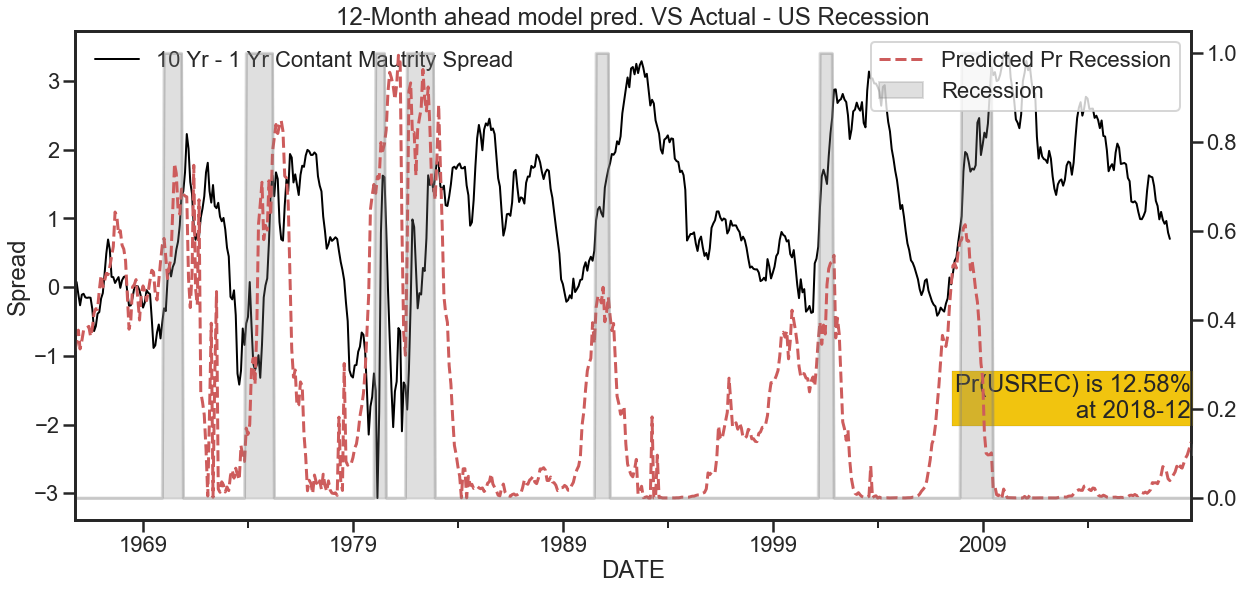

In [43]:
fig0, ax0 = plt.subplots(figsize=(20, 9))
ax1 = ax0.twinx()
pred_act_df['T10Y1YM'].plot(kind='line', stacked=False, ax=ax0, color='black',LW=2, label="10 Yr - 1 Yr Contant Mautrity Spread")
pred_act_df['PRED_USREC1'].plot(kind='line', secondary_y=True,stacked=False, linestyle='--', ax=ax1, color='INDIANRED',LW=3, label="Predicted Pr Recession")
pred_act_df['USREC'].plot(kind='area', secondary_y=True, ax=ax1, alpha=.25, color='grey',label='Recession')
#plt.ylim(ymin=0.0, ymax=0.8)
ax0.set_ylabel('Spread')
ax1.set_ylabel("Probability")
ax1.set_ylim(0,1)
vals = ax0.get_yticks()
legend=ax0.legend(loc='upper left', fancybox=True, framealpha=0)
plt.title('12-Month ahead model pred. VS Actual - US Recession')
plt.legend(loc='upper right')
#plt.axis('off')
xlast = pred_act_df.last_valid_index()
ylast = pred_act_df.loc[xlast,'PRED_USREC1']
print(xlast,ylast)
text= "Pr(USREC) is {:3.2f}%\n   at {}".format(ylast*100, xlast)
if not ax0:
        ax0=plt.gca()
bbox_props = dict(boxstyle="square,pad=0.1", fc="#F1C40F", ec="k", lw=0.1)
arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
kw = dict(xycoords='data',textcoords="axes fraction",arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
ax1.annotate(text, xy=(xlast, ylast),xytext=(1,0.3),**kw)

In [44]:
write = pd.ExcelWriter(r'C:\Work\03. Economic Data\201801\USREC.xlsx')
pred_act_df.to_excel(write,'Sheet2')
write.save()